   # Analisi delle frodi bancarie mediante pySpark Machine Learning

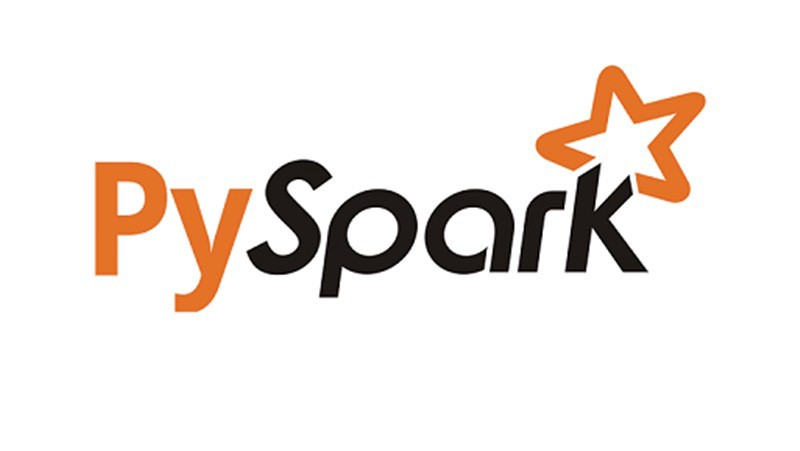

## INDICE

1) CASO ANALIZZATO E STATO DELL'ARTE

2) DATA FLOW

3) LETTURA E VISUALIZZAZIONE DEI DATI (DATASET)

4) BILANCIAMENTO DELLE CLASSI MEDIANTE UNDERSAMPLING [SAMPLING]

5) PRE-PROCESSAMENTO DEI DATI [PRE-PROCESSING]

6) RIMOZIONE OUTLIERS [DATA VERACITY]

7) NORMALIZZAZIONE FEATURE [DATA SCALING]

8) APPLICAZIONE MODELLI PYSPARK MACHINE LEARNING AL DATASET UNDERSAMPLED [TRAINING MODEL, TESTING MODEL, MODEL EVALUATION]

9) BILANCIAMENTO DELLE CLASSI MEDIANTE OVERSAMPLING SMOTE

10) APPLICAZIONE MODELLI PYSPARK MACHINE LEARNING AL DATASET OVERSAMPLED

11) CONFRONTO TRA I MODELLI OTTENUTI CON UNDERSAMPLING E OVERSAMPLING

12) CONCLUSIONI

### 1. CASO ANALIZZATO E STATO DELL'ARTE

Un ambito molto importante al giorno d'oggi è la predizione di transazioni fraudolente nell'ambito bancario. Quando si trattano questi dati, il problema in cui si incorre è quello dell'imbalance, le transazioni a disposizione sono per la maggior parte leggittime e solo una piccola percentuale fraudolente. Le transazioni fraudolente a nostra disposizione sono quelle che ogni utente segnala alla propria banca come non riconosciute. Inoltre risulta molto spesso che le segnalazioni che arrivano da parte degli utenti in alcuni casi sono solamente dei pagamenti che vengono effettuati in automatico sulla propria carta. 
Dovuti alla sottoscrizione di abbonamenti che l'utente non ricorda di aver sottoscritto. 
Risulta quindi, molto difficile addestrare i modelli con questo tipo di dati. 

Per ovviare all'imbalance dei dati esistono diverse soluzioni:

1. Undersampling del dataset
2. Oversampling del dataset
3. Metodi Ensemble

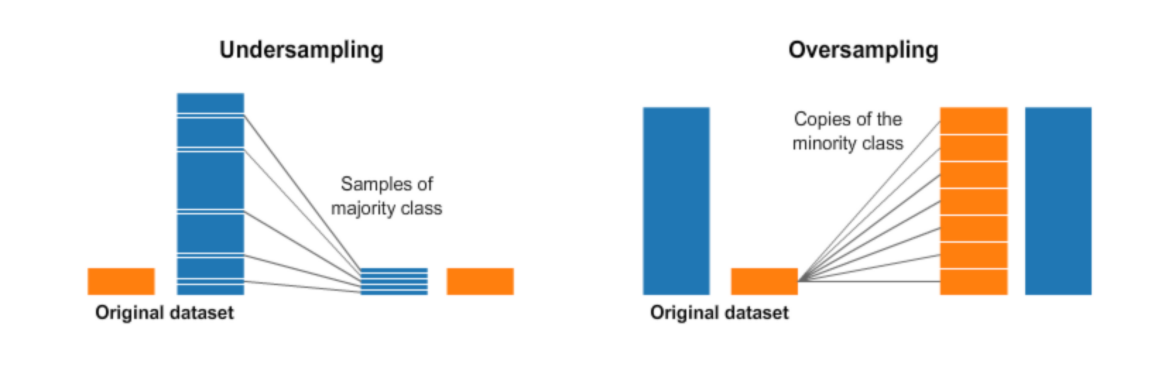

Inoltre le metriche più utilizzate in questi casi di dataset imbalance che variano molto in base al numero dei falsi negativi sono:

1. Recall è anche chiamata sensitivity o true positive rate: indica il rapporto di istanze positive correttamente individuate dal sistema di machine learning e si misua come TP / (TP + FN).
2. F1 Score che tiene conto della Precision and Recall, che si misura come TP / (TP + (FN+FP/2)) che è anche uguale a 2 * (Precision * Recall) / (Precision + Recall).
3. Negative predictive value (NPV) che si misura come TN / (TN + FN).

#### Dati a disposizione

Il dataset a nostra disposizione è stato scaricato dalla piattaforma Kaggle, contiene transazioni fatte tramite carta di credito nel Settembre 2013 da persone residenti in Europa.
Abbiamo transazioni effettuate in un tempo di due giorni, e abbiamo 492 transazioni fraudolente su 284'807, per cui il dataset è fortemente sbilanciato.
Abbiamo quindi lo 0.172% di transazioni fraudolente.

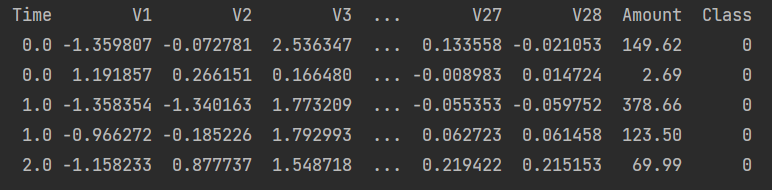

Contiene solamente variabili numeriche che è il risultato di una trasformazione dei dati mediante PCA per rendere privati i dati degli utenti. Le variabili a V1 a V28 sono le componenti principali e inoltre abbiamo le variabili time e amount e la variabile Class che è 1 quando la transazione è classificata come frode e 0 viceversa.
Come abbiamo detto il nostro dataset è sbilanciato (Data Imbalanced)!

#### Obiettivo

L'obiettivo del progetto è quello di riuscire a prevedere secondo determinate metriche quali transazioni future dovranno essere classificate come frode e quali no, mediante l'utilizzo di pySpark machine learning. Sono stati utilizzati algoritmi di classificazione quali Gradient Boosting Tree e Random Forest, in quanto algoritmi che si comportano bene in casi di classificazione di questo tipo. Le metriche che sono state utilizzate sono la Recall, la Specificity e la F1-Score. Queste tre metriche tengono conto in maniera particolare dei Falsi negativi (transazioni legittime ma che in realtà sono fraudolente), che sono i valori che le banche vorrebbero minimizzare, in quanto si hanno forti perdite per numeri elevati di questi dati. I Falsi positivi sono invece quelle transazioni che sono leggittime ma vengono classificate come fraudolente, che ovviamente non devono essere altissime ma in questo caso non verranno tenuti particolarmente d'occhio perchè le banche tendono a perdere molto meno.


### 2. DATA FLOW

Il lavoro proposto seguirà determinati passi che vediamo dalla rappresentazione grafica del dataflow, il dataset è stato trattato prima ha subito delle modifiche per poi essere utilizzato per valutare i modelli. Per chiarezza grafica è sono stati rappresentati i vari passi che si sono percorsi, sebbene si sia proceduto secondo due approcci. 

Il primo che ha visto l'applicazione dell'algoritmo undersampling al training set, con una riduzione notevole del numero di osservazioni. Successivamente nel preprocessing si sono rimosse le feature correlate tra loro così da tenere solamente quelle indipendenti. Poi si è passato alla Data Veracity, che consiste nel rendere i dati accurati puliti ed efficaci. Infine si sono normalizzate alcune variabili, addestrati i modelli del Gradient Boosting Tree e Random Forest e valutate le performance sul test set sbilanciato mediante le metriche Recall, Specificity e F1 Score.

Per il secondo approccio si è applicato l'oversampling mediante la libreria SMOTE e create nuove variabili fraudolente per diminuire lo sbilanciamento del dataset. La funzione SMOTE si è applicata due volte, una volta creando un dataset con bilanciato di circa 400 mila osservazioni, con il 50% di transazioni fraudolente, la seconda volta si è sempre usata la funzione SMOTE, creando un dataset con il 10% di transazioni fraudolente. Non si è effettuato nessun pre processing per l'onerosità del modello. Infine si sono addestrati gli algoritimi di classificazione del GBT e Random Forest e utilizzate le metriche sul test set sbilanciato, Recall, Specificity e F1 Score

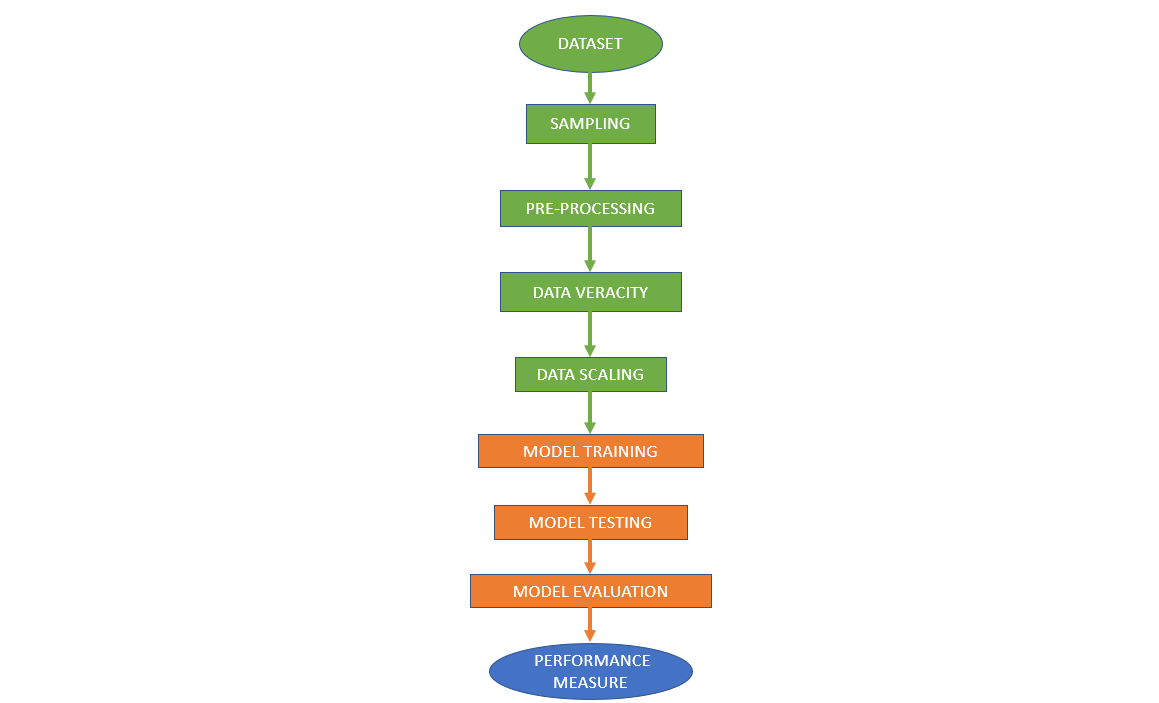

### 3. LETTURA E VISUALIZZAZIONE DEI DATI (DATASET)

#### Caricamento librerie

In [1]:
import findspark
findspark.init()

In [2]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from collections import Counter

In [3]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
spark = SparkSession.builder.master("local[*]").getOrCreate() # creazione della sessione spark

#### Lettura del dataset mediante pandas e breve sommario della struttura dei dati a nostra disposizione

In [4]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


#### Cerchiamo eventuali valori nulli nelle nostre variabili

In [6]:
df.isnull().sum().max()

0

#### Struttura delle colonne a disposizione

In [7]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

I dati hanno una colonna chiamata 'Time', che sono i secondi che partono da zero, cioè il momento della prima transazione bancaria, fino all'ultima. 

Ho deciso di convertirle in ore cosi da vedere quali fossero le ore della giornata con più transazioni frodi e non. 

In [8]:
df['hour'] = df['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)

In [9]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'hour'],
      dtype='object')

In [10]:
df.pivot_table(values='Amount',index='hour',columns='Class',aggfunc='count')

Class,0,1
hour,,
0.0,10919,21
1.0,7687,6
2.0,4212,10
3.0,3269,57
4.0,3476,17
5.0,2185,23
6.0,2979,11
7.0,4093,9
8.0,7219,23


In [11]:
def PlotHistogram(df,norm):
    bins = np.arange(df['hour'].min(),df['hour'].max()+2)
    plt.figure(figsize=(15,4))
    sns.distplot(df[df['Class']==0.0]['hour'],
                 norm_hist=norm,
                 bins=bins,
                 kde=False,
                 color='b',
                 hist_kws={'alpha':.5},
                 label='Legit')
    sns.distplot(df[df['Class']==1.0]['hour'],
                 norm_hist=norm,
                 bins=bins,
                 kde=False,
                 color='r',
                 label='Fraud',
                 hist_kws={'alpha':.5})
    plt.xticks(range(0,24))
    plt.legend()
    plt.show()

Mostriamo due grafici, uno con le quantità di transazioni normalizzate, così da vedere la differenza tra le frodi e non frodi, e l'altro con il conteggio per tipo di transazione. Entrambe in base all'ora del giorno.

Normalized histogram of Legit/Fraud over hour of the day


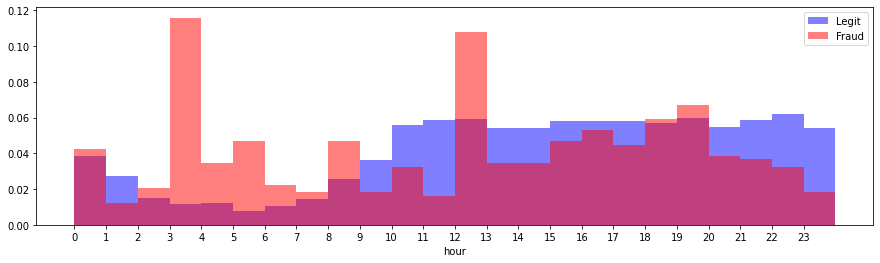

Counts histogram of Legit/Fraud over hour of the day
*you can barely see the Fraud cases since there are so little of them.


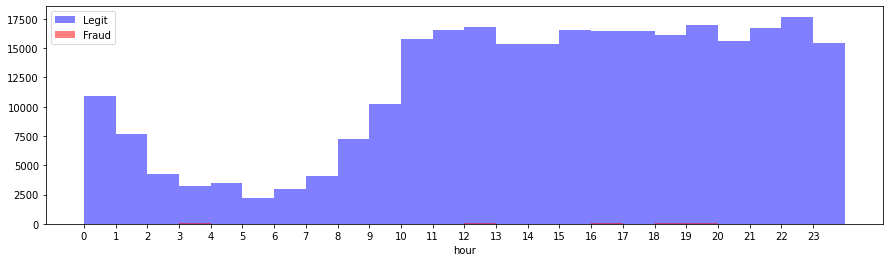

1.6436493396759033


In [152]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

start = time.time()
print('Normalized histogram of Legit/Fraud over hour of the day')
PlotHistogram(df,True)
print('Counts histogram of Legit/Fraud over hour of the day')
print('*you can barely see the Fraud cases since there are so little of them.')
PlotHistogram(df,False)
print(time.time()-start)

Si è notato dal primo grafico che le ora di punta delle transazioni fraudolente sono in particolare tra le 3 del mattino e le 4, e tra le 12 e le 13. Questo probabilmente dovuto al fatto che si preferisce truffare nelle ore della notte e nelle ore di pranzo. Ore in cui le persone destano meno attenzione.

### 4. BILANCIAMENTO DELLE CLASSI MEDIANTE UNDERSAMPLING [SAMPLING]

#### PRIMO APPROCCIO UNDERSAMPLING 

Come abbiamo detto prima, ci sono diversi modi per ricampionare i dataset sbilanciati. 

Il modo in cui sotto-campioneremo il dataset di training sarà quello di creare un rapporto 50/50 utilizzando l'undersampling. Questo sarà fatto selezionando casualmente le transazioni non fraudolente presa in considerazione la quantità di campione della classe di minoranza.

Come vediamo dal grafico sottostante il nostro dataset è fortemente sbilanciato, applicchiamo ora l'algoritmo di undersampling.

#### Scomposizione dataset di training e test

In [13]:

import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df,df.Class, test_size=0.1, random_state=42) 

In [14]:
X_train

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour
17196,28515.0,1.226643,0.101988,-0.087072,0.111524,-0.281992,-1.356027,0.469050,-0.371725,-0.153672,...,-1.153663,0.109793,0.420318,0.197932,0.699218,-0.114861,0.007583,50.40,0,8.0
139378,83125.0,1.124848,0.125602,0.249962,0.489744,-0.040386,0.167561,-0.247614,0.284736,-0.067302,...,-0.576819,0.190343,-0.357451,0.000870,0.139971,-0.000993,0.011505,1.98,0,0.0
119668,75537.0,-0.307902,1.003715,1.404277,0.592627,0.311014,-0.382106,0.531393,-0.015292,-0.758638,...,-0.329268,0.046990,0.057413,-0.656960,0.193192,0.142038,0.157501,1.98,0,21.0
253676,156358.0,2.174919,-1.535441,-0.726428,-1.430792,-1.517258,-0.751038,-1.155344,-0.180811,-1.111885,...,0.050018,0.294666,1.123322,-0.306025,-0.241343,0.006553,-0.027567,64.00,0,20.0
266881,162523.0,-2.221556,1.261987,2.047642,4.659268,-0.535941,4.542044,-3.715525,-5.311701,-0.955321,...,0.873723,-2.648598,-0.162180,-0.492111,0.601490,0.627030,0.088289,379.29,0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,75618.0,1.173488,0.100792,0.490512,0.461596,-0.296377,-0.213165,-0.165254,0.119221,-0.114199,...,-0.574283,0.161405,-0.006140,0.091444,0.109235,-0.020922,0.003967,1.98,0,22.0
259178,159000.0,-0.775981,0.144023,-1.142399,-1.241113,1.940358,3.912076,-0.466107,1.360620,0.400697,...,-0.019575,0.241830,0.682820,-1.635109,-0.770941,0.066006,0.137056,89.23,0,21.0
131932,79795.0,-0.146609,0.992946,1.524591,0.485774,0.349308,-0.815198,1.076640,-0.395316,-0.491303,...,0.354089,-0.291198,0.402849,0.237383,-0.398467,-0.121139,-0.196195,3.94,0,23.0
146867,87931.0,-2.948638,2.354849,-2.521201,-3.798905,1.866302,2.727695,-0.471769,2.217537,0.580199,...,-1.047514,0.143326,0.678869,0.319710,0.426309,0.496912,0.335822,1.00,0,1.0


In [15]:
X_test['Class'].value_counts()[1]

46

In [16]:
X_test['Class'].value_counts()[0]

28435

Distribution of the Classes in the dataset
0    0.998214
1    0.001786
Name: Class, dtype: float64


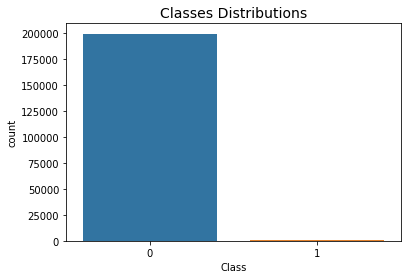

In [153]:
print('Distribution of the Classes in the dataset')
print(X_train['Class'].value_counts()/len(X_train))

sns.countplot('Class', data=X_train)
plt.title('Classes Distributions', fontsize=14)
plt.show()

In [18]:
# Numero delle transazioni fraudolente
X_train = X_train.reset_index()
number_records_fraud = len(X_train[X_train.Class == 1])

# Creiamo l'indice
fraud_indices = np.array(X_train[X_train.Class == 1].index)

In [19]:

normal_indices = X_train[X_train.Class == 0].index

# Prendiamo le transazioni random classificate come 0
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Concateniamo gli indici
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Creiamo il dataset
under_sample_df = X_train.iloc[under_sample_indices,:]

X_undersample = under_sample_df.loc[:, under_sample_df.columns != 'Class']
y_undersample = under_sample_df.loc[:, under_sample_df.columns == 'Class']

print("normal data distribution: {}".format(Counter(X_train["Class"].values)))
print("UNDERSAMPLE data distribution: {}".format(Counter(under_sample_df["Class"].values)))

normal data distribution: Counter({0: 255880, 1: 446})
UNDERSAMPLE data distribution: Counter({1: 446, 0: 446})


In [20]:
# Ora il dataset risulta bilanciato

### 5. PRE-PROCESSAMENTO DEI DATI [PRE-PROCESSING]

#### - Rimozione features dipendenti

Si è deciso di rappresentare mediante una matrice, la correlazione pre e post undersample.
Si nota come nella prima matrice le features siano totalmente dipendenti, mentre nel dataset post undersample abbiamo alcune features correlate. Dato questo, abbiamo deciso di creare un nuovo dataset tenendo solamente le features indipendenti.

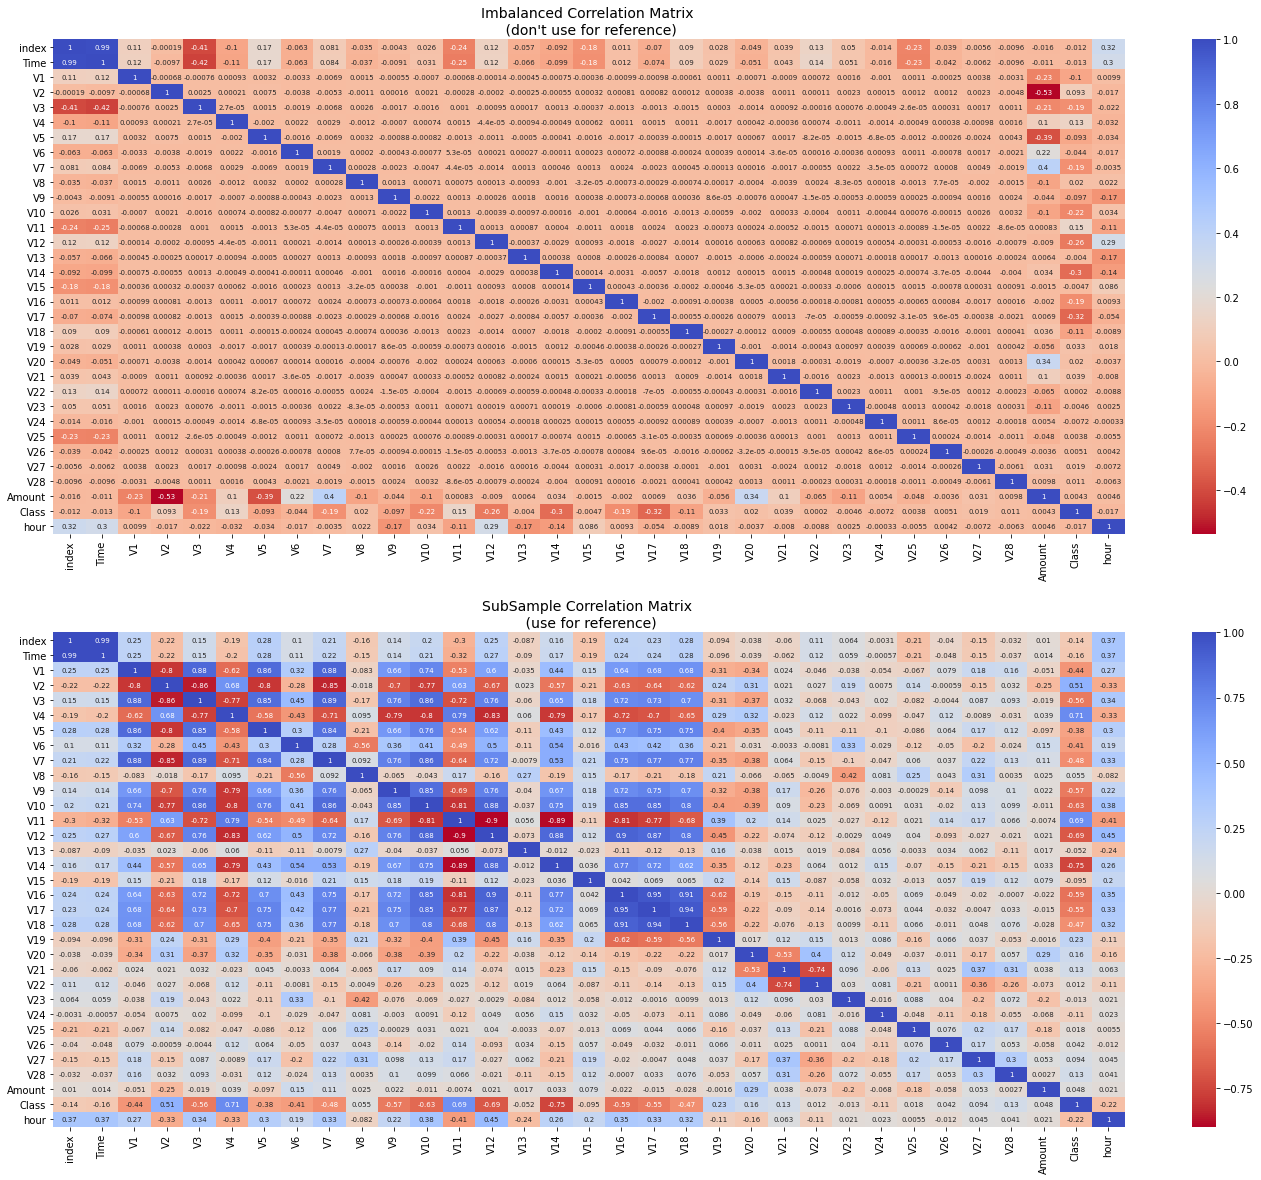

In [21]:
f, (ax1,ax2) = plt.subplots(2, 1, figsize=(24,20))

# Dataset Iniziale
corr = X_train.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':7}, ax=ax1, annot=True)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

# Dataset creato col sample

sub_sample_corr = under_sample_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':7}, ax=ax2, annot=True)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()


Text(0.5, 1.0, "Imbalanced Correlation Matrix \n (don't use for reference)")

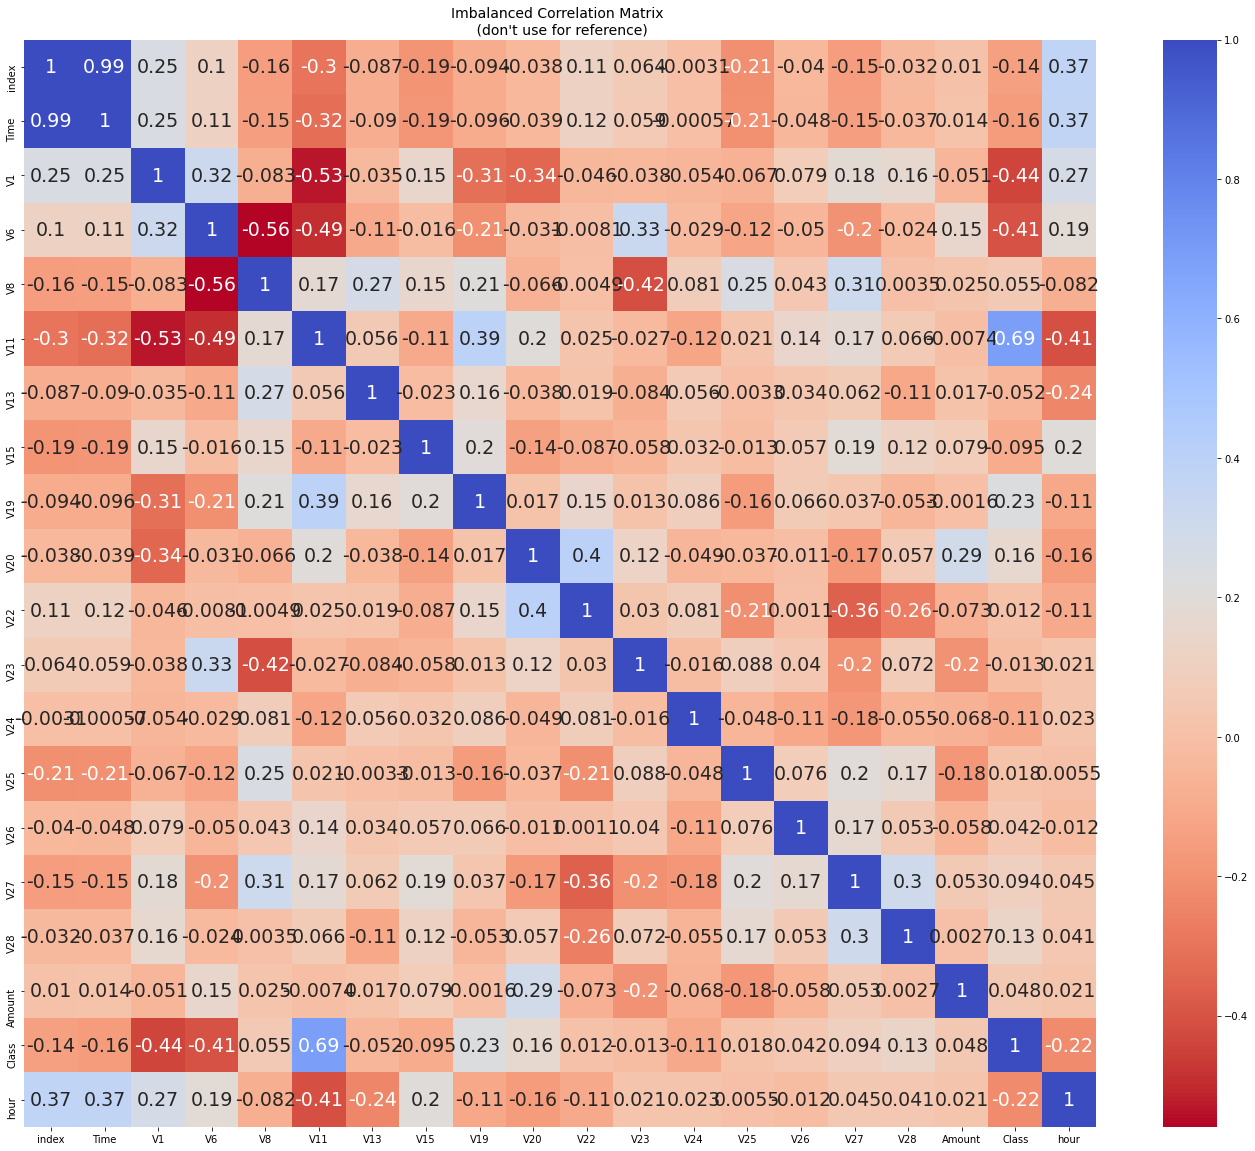

In [22]:
# Rimuoviamo le features fortemente correlate e rifacciamo la matrice

dfs = under_sample_df.drop(['V2', 'V3', 'V4', 'V5', 'V7','V9', 'V10','V12','V14','V16','V17','V18','V21'], axis=1)


f, (ax1) = plt.subplots(1, 1, figsize=(24,20))

# Entire DataFrame
corr = dfs.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':19}, ax=ax1, annot=True)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)

### 6. RIMOZIONE OUTLIERS [DATA VERACITY]

In [23]:
# Avendo sistemato parzialmente il dataset, si è deciso di rimuovere gli outliers delle
# features V1, V6 e V11 in quanto sono quelle che influenzano negativamente o positivamente 
# la nostra variabile di risposta Class. 
# In termini pratici Class è molto sensibile agli outliers di queste 3 features.

under_sample_df = dfs
X_test = X_test.drop(['V2', 'V3', 'V4', 'V5', 'V7','V9', 'V10','V12','V14','V16','V17','V18','V21'], axis=1)
under_sample_df

,index,Time,V1,V6,V8,V11,V13,V15,V19,V20,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour
322,94218,64785.0,-8.744415,0.105512,0.940378,5.267862,0.173896,2.084199,1.332930,-1.818315,0.311626,-4.129195,0.034639,-1.133631,0.272265,1.841307,-1.796363,720.38,1,18.0
1648,88876,62330.0,1.140865,-0.981223,-0.037721,0.915947,-0.523377,0.421013,-1.100764,-0.067712,-0.793460,-0.132333,-0.331586,0.664878,-0.309312,0.099942,0.122988,1.00,1,18.0
2442,42007,40918.0,-3.140260,-0.721552,-0.598346,3.823762,-1.524367,-0.391215,-0.871582,0.077781,-0.292963,-0.189330,-0.166482,0.038040,-0.015477,0.776691,0.397557,0.76,1,12.0
2490,163586,116067.0,0.949241,-2.562826,0.260906,2.453710,-1.200412,1.014897,0.520497,0.424608,-0.854627,0.101177,-0.281497,0.024444,-0.107944,0.625289,0.315677,65.00,1,9.0
2574,79536,58067.0,-0.264869,-2.053918,-2.957235,1.847504,-2.573225,0.123470,-3.602657,0.482513,-0.166029,-1.452081,-0.251815,1.243461,0.452787,0.132218,0.424599,1.00,1,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133620,110276,71752.0,-3.294245,-0.130531,0.903595,1.872657,0.460431,1.388937,1.336282,0.276626,-0.256944,0.112367,0.194634,-0.694923,0.106656,-1.490907,-0.533858,21.28,0,20.0
20229,212514,138892.0,1.944686,0.434591,0.060436,-0.162826,-1.560110,-1.559549,-1.112168,-0.352069,0.771005,-0.072600,0.273558,0.404875,0.273513,-0.078268,-0.074444,7.57,0,15.0
127717,244330,152306.0,2.041742,-0.203622,-0.109889,0.373544,-0.710030,-0.915787,0.155569,-0.220230,0.025918,-0.094048,-0.251050,0.538875,-0.489754,-0.009099,-0.041277,7.66,0,19.0
49848,271183,164450.0,-0.861146,2.972026,0.926420,-2.801173,-0.243662,-0.899848,1.847279,0.179586,0.575126,-0.390024,0.120929,0.185801,0.627973,-0.194026,-0.214857,75.64,0,22.0


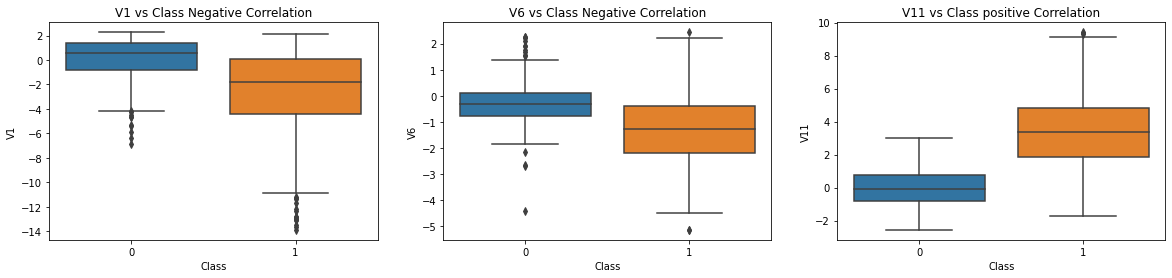

In [151]:
f, axes = plt.subplots(ncols=3, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V1", data=under_sample_df,  ax=axes[0])
axes[0].set_title('V1 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V6", data=under_sample_df,  ax=axes[1])
axes[1].set_title('V6 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V11", data=under_sample_df,  ax=axes[2])
axes[2].set_title('V11 vs Class positive Correlation')

plt.show()

Possiamo vedere gli outliers nei boxplot e la distribuzione delle variabili, rimuoviamo solo alcuni perchè abbiamo poche variabili

In [25]:
# Rimuoviamo gli outliers di V1

v1_fraud = under_sample_df['V1'].loc[under_sample_df['Class'] == 1].values
q25, q75 = np.percentile(v1_fraud, 25), np.percentile(v1_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v1_iqr = q75 - q25
print('iqr: {}'.format(v1_iqr))

v1_cut_off = v1_iqr * 1.5
v1_lower, v1_upper = q25 - v1_cut_off, q75 + v1_cut_off
print('Cut Off: {}'.format(v1_cut_off))
print('V1 Lower: {}'.format(v1_lower))
print('V1 Upper: {}'.format(v1_upper))

outliers = [x for x in v1_fraud if x < v1_lower or x > v1_upper]
print('Feature V1 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V1 outliers:{}'.format(outliers))

under_sample_df = under_sample_df.drop(under_sample_df[(under_sample_df['V1'] > v1_upper)
                                                       | (under_sample_df['V1'] < v1_lower)].index)
print('----' * 44)

# Rimuoviamo gli outliers di V6
v6_fraud = under_sample_df['V6'].loc[under_sample_df['Class'] == 1].values
q25, q75 = np.percentile(v6_fraud, 25), np.percentile(v6_fraud, 75)
v12_iqr = q75 - q25

v6_cut_off = v12_iqr * 1.5
v6_lower, v6_upper = q25 - v6_cut_off, q75 + v6_cut_off
print('V6 Lower: {}'.format(v6_lower))
print('V6 Upper: {}'.format(v6_upper))
outliers = [x for x in v6_fraud if x < v6_lower or x > v6_upper]
print('V6 outliers: {}'.format(outliers))
print('Feature V6 Outliers for Fraud Cases: {}'.format(len(outliers)))
under_sample_df = under_sample_df.drop(under_sample_df[(under_sample_df['V6'] > v6_upper) 
                                                       | (under_sample_df['V6'] < v6_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(under_sample_df)))
print('----' * 44)

# Rimuoviamo gli outliers di V11
v11_fraud = under_sample_df['V11'].loc[under_sample_df['Class'] == 1].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
v11_iqr = q75 - q25


v11_cut_off = v11_iqr * 1.5
v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
print('V11 Lower: {}'.format(v11_lower))
print('V11 Upper: {}'.format(v11_upper))
outliers = [x for x in v11_fraud if x < v11_lower or x > v11_upper]
print('V11 outliers: {}'.format(outliers))
print('Feature V11 Outliers for Fraud Cases: {}'.format(len(outliers)))
under_sample_df = under_sample_df.drop(under_sample_df[(under_sample_df['V11'] > v11_upper) 
                                                       | (under_sample_df['V11'] < v11_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(under_sample_df)))


type(under_sample_df)

Quartile 25: -5.95428742757648 | Quartile 75: -0.25482039098549625
iqr: 5.699467036590984
Cut Off: 8.549200554886475
V1 Lower: -14.503487982462955
V1 Upper: 8.294380163900978
Feature V1 Outliers for Fraud Cases: 44
V1 outliers:[-28.2550528932108, -25.825982149082, -25.2663550194138, -29.2003285905744, -27.1436784229495, -19.8563223334433, -15.8191787207718, -17.9762660516057, -14.9703456545046, -18.474867903441, -22.5616992591298, -15.1920640113629, -19.6418567335974, -21.2091195927913, -18.2475132286673, -19.1798264145873, -19.1397328634111, -16.5986647432584, -17.2751911945397, -24.5902447690465, -26.4577446501446, -23.237920244511, -26.4577446501446, -15.1404496225073, -15.9036352020113, -23.9141008948243, -27.84818067198, -23.9847466495794, -16.308650062507, -15.3988450085358, -21.8854339051741, -26.4577446501446, -18.0185611876771, -30.552380043581, -22.3418888868038, -17.5375916846763, -17.4677100117887, -15.2713618637585, -28.5242675938406, -16.9174682656955, -17.5189091261484, 

pandas.core.frame.DataFrame

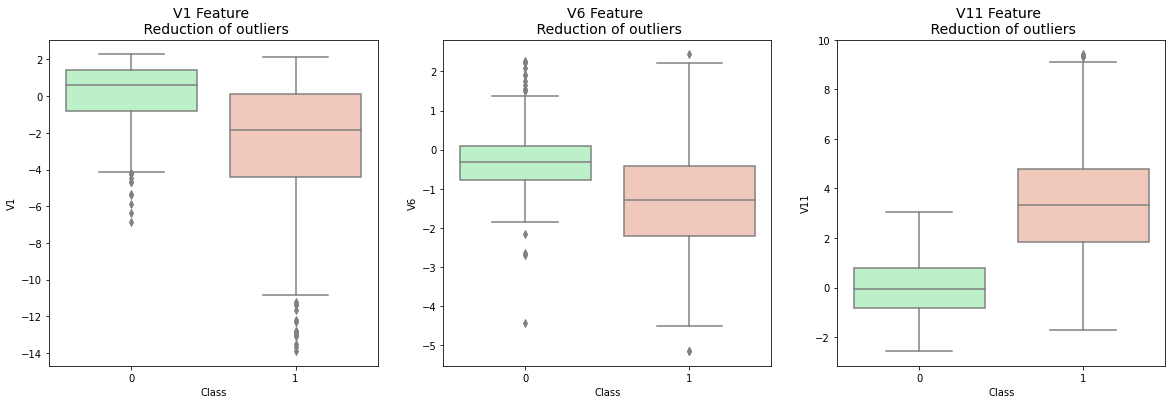

In [26]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']

# Boxplots with outliers removed
# Feature V1
sns.boxplot(x="Class", y="V1", data=under_sample_df,ax=ax1, palette=colors)
ax1.set_title("V1 Feature \n Reduction of outliers", fontsize=14)
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature 11
sns.boxplot(x="Class", y="V6", data=under_sample_df, ax=ax2, palette=colors)
ax2.set_title("V6 Feature \n Reduction of outliers", fontsize=14)
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

# Feature V11
sns.boxplot(x="Class", y="V11", data=under_sample_df, ax=ax3, palette=colors)
ax3.set_title("V11 Feature \n Reduction of outliers", fontsize=14)
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


plt.show()

### 7. NORMALIZZAZIONE FEATURE [DATA SCALING]

Mediante il RobustScaler di pyspark si è deciso di normalizzare le variabili Amount e hour

In [27]:
from pyspark.ml.feature import VectorAssembler # unisce i nostri predittori
from pyspark.ml.feature import RobustScaler #utilizzato per normalizzare le variabili

In [28]:
data = spark.createDataFrame(under_sample_df)
data_test =spark.createDataFrame(X_test)

In [29]:
assembler = VectorAssembler(inputCols=["Amount","hour"], outputCol="features")


In [30]:
assembled = assembler.transform(data) 
assembled_test = assembler.transform(data_test)
#applichiamo l'asssembler al nostro dataframe spark

In [31]:
assembled.show()

+------+--------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+-------+-----+----+--------------+
| index|    Time|                V1|                V6|                 V8|               V11|               V13|               V15|               V19|                V20|               V22|                V23|                V24|               V25|                V26|               V27|                V28| Amount|Class|hour|      features|
+------+--------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+-------------------+------------------+-------------------+------

In [32]:
assembled_test.show()

+--------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------+-----+----+-------------+
|    Time|                V1|                V6|                 V8|                V11|                V13|                V15|                V19|                V20|                V22|                V23|                V24|                V25|                V26|                V27|                V28|Amount|Class|hour|     features|
+--------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------+---

In [33]:
scaler = RobustScaler(inputCol="features", outputCol="scaledFeatures") #normalizziamo le variabili

In [34]:
#il vettore features sono i nostri predittori uniti, quello scaledFeatures le nostre variabili normalizzate

In [35]:
scaled = scaler.fit(assembled).transform(assembled)
scaled_test = scaler.fit(assembled_test).transform(assembled_test)

In [36]:
scaled.select("features", "scaledFeatures").show()

+--------------+--------------------+
|      features|      scaledFeatures|
+--------------+--------------------+
| [720.38,18.0]|[7.34257466109469...|
|    [1.0,18.0]|[0.01019264091326...|
|   [0.76,12.0]|[0.00774640709407...|
|    [65.0,9.0]|[0.66252165936194...|
|    [1.0,17.0]|[0.01019264091326...|
|    [1.0,23.0]|[0.01019264091326...|
|  [104.81,9.0]|[1.06829069411884...|
|[1504.93,19.0]|[15.3392110895933...|
|     [0.0,5.0]|         [0.0,0.625]|
|   [4.49,16.0]|[0.04576495770054...|
|   [0.76,15.0]|[0.00774640709407...|
| [130.44,16.0]|[1.32952808072571...|
|  [316.06,3.0]|[3.22148608704515...|
| [444.17,16.0]|[4.52726531444297...|
|    [1.0,22.0]|[0.01019264091326...|
|   [1.79,16.0]|[0.01824482723473...|
|  [99.99,12.0]|[1.01916216491693...|
|    [0.76,0.0]|[0.00774640709407...|
| [454.82,17.0]|[4.63581694016919...|
| [247.86,19.0]|[2.52634797676077...|
+--------------+--------------------+
only showing top 20 rows



In [37]:
data = data.drop("Amount","hour","features")
data_test = data_test.drop("Amount","hour","features")

### 8. APPLICAZIONE MODELLI PYSPARK MACHINE LEARNING AL DATASET UNDERSAMPLING

In [38]:
classFreq = data.groupBy("Class").count()
classFreq.show()
toPlot = classFreq.toPandas()

+-----+-----+
|Class|count|
+-----+-----+
|    0|  407|
|    1|  382|
+-----+-----+



In [39]:
classFreq = data_test.groupBy("Class").count()
classFreq.show()
toPlot = classFreq.toPandas()

+-----+-----+
|Class|count|
+-----+-----+
|    0|28435|
|    1|   46|
+-----+-----+




#### Aggiunta dell'index per tenere traccia delle righe

In [40]:
from pyspark.sql.window import Window
win = Window().orderBy('Time')
data = data.withColumn("idx", row_number().over(win))


In [41]:
from pyspark.sql.window import Window
win = Window().orderBy('Time')
data_test = data_test.withColumn("idx", row_number().over(win))

#### Importazione delle librerie Pyspark machine learning

In [42]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [43]:
data.columns

['index',
 'Time',
 'V1',
 'V6',
 'V8',
 'V11',
 'V13',
 'V15',
 'V19',
 'V20',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Class',
 'idx']

In [44]:
data_test.columns

['Time',
 'V1',
 'V6',
 'V8',
 'V11',
 'V13',
 'V15',
 'V19',
 'V20',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Class',
 'idx']

#### Conversione delle colonne delle features mediante in DenseVector e creazione della variabile label e indice

In [45]:
training_df = data.rdd.map(lambda x: (DenseVector(x[1:16]),x[17],x[18]))
test_df = data_test.rdd.map(lambda x: (DenseVector(x[0:15]),x[16],x[17]))

In [46]:
training_df = spark.createDataFrame(training_df,["features","label","index"])
test_df = spark.createDataFrame(test_df,["features","label","index"])

In [47]:
training_df.show()

+--------------------+-----+-----+
|            features|label|index|
+--------------------+-----+-----+
|[406.0,-2.3122265...|    1|    1|
|[472.0,-3.0435406...|    1|    2|
|[2977.0,1.1220494...|    0|    3|
|[4462.0,-2.303349...|    1|    4|
|[4485.0,-2.220662...|    0|    5|
|[6986.0,-4.397974...|    1|    6|
|[7399.0,-0.383561...|    0|    7|
|[7519.0,1.2342350...|    1|    8|
|[7526.0,0.0084303...|    1|    9|
|[7535.0,0.0267792...|    1|   10|
|[7543.0,0.3295943...|    1|   11|
|[7551.0,0.3164590...|    1|   12|
|[7610.0,0.7256457...|    1|   13|
|[7668.0,1.0321293...|    0|   14|
|[7672.0,0.7027099...|    1|   15|
|[7687.0,1.2513803...|    0|   16|
|[7740.0,1.0238738...|    1|   17|
|[7891.0,-1.585505...|    1|   18|
|[8090.0,-1.783228...|    1|   19|
|[8169.0,0.8573210...|    1|   20|
+--------------------+-----+-----+
only showing top 20 rows



In [48]:
test_df.show()

+--------------------+-----+-----+
|            features|label|index|
+--------------------+-----+-----+
|[0.0,-1.359807133...|    0|    1|
|[4.0,1.2296576345...|    0|    2|
|[10.0,1.249998742...|    0|    3|
|[12.0,1.103215435...|    0|    4|
|[22.0,-1.94652513...|    0|    5|
|[23.0,1.173284610...|    0|    6|
|[26.0,-0.52991228...|    0|    7|
|[32.0,-2.00887179...|    0|    8|
|[35.0,-1.06323567...|    0|    9|
|[50.0,-0.67170854...|    0|   10|
|[56.0,0.086996190...|    0|   11|
|[56.0,-0.84799836...|    0|   12|
|[59.0,-0.77329260...|    0|   13|
|[70.0,-0.42607169...|    0|   14|
|[73.0,0.925996612...|    0|   15|
|[76.0,-0.99717575...|    0|   16|
|[76.0,-1.02457604...|    0|   17|
|[77.0,-1.16572174...|    0|   18|
|[77.0,-1.18595403...|    0|   19|
|[80.0,-3.00773905...|    0|   20|
+--------------------+-----+-----+
only showing top 20 rows



In [49]:
training_df.groupBy("label").count().show() #variabili nel training

+-----+-----+
|label|count|
+-----+-----+
|    0|  407|
|    1|  382|
+-----+-----+



In [50]:
test_df.groupBy("label").count().show() # variabili nel test

+-----+-----+
|label|count|
+-----+-----+
|    0|28435|
|    1|   46|
+-----+-----+



#### Creazione del modello utilizzando il Gradient Boosting Tree Classifier, che come abbiamo accennato prima, è uno dei modelli più efficaci per la predizione delle frodi bancarie assieme al Random Forest

Costruisce un modello in maniera simile ai metodi di boosting, l'algoritmo assegna dei pesi ad ogni modello risultante. Ad un modello con un buon risultato di classificazione sui dati di formazione verrà assegnato un peso maggiore rispetto ad uno scarso. Così, quando si valuta un nuovo modello, il Boosting terrà conto anche degli errori dati dai modelli precedenti.

In [51]:
gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=4) # 100 trees, con profondità 2

### [MODEL TRAINING]

In [52]:
model = gbt.fit(training_df) # addestriamo il modello

### [MODEL TESTING]

In [53]:
predictions = model.transform(test_df) # facciamo la predizione sul test set

#### Vediamo le classi predette

In [56]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))

In [57]:
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   41|
|              0|28440|
+---------------+-----+



In [58]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|28435|
|    1|   46|
+-----+-----+



In [59]:
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]

In [60]:
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]


### [MODEL EVALUATION]

In [61]:
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100

In [62]:
FraudPredictionAccuracy

89.13043478260869

#### Matrice di confusione

In [63]:
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()

In [64]:
tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()

In [65]:
fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()

In [66]:
fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()

In [67]:
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)

True Positive:  41 
True Negative:  25409 
False Positive:  3026 
False Negative:  5


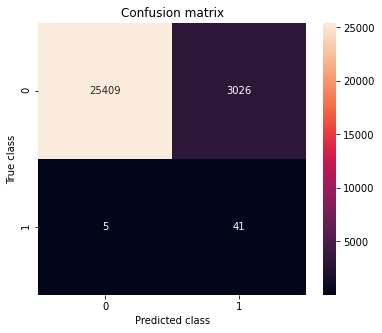

In [68]:
import matplotlib.pyplot as plt
import numpy as np

#visulalizing the confusion matrix
LABELS = [0, 1] 
conf_matrix = np.array([[tn, fp],
               [fn, tp]])
plt.figure(figsize =(6, 5)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show() 

### METRICS PERFORMANCE

### Recall

In [69]:
print("Recall: ",tp/(tp+fn))

Recall:  0.8913043478260869


### True negative rate/Specificity

In [70]:
print("Specificity: ",tn/(tn+fp))

Specificity:  0.893581853349745


### F1 Score

In [72]:
 print("F1 Score: " ,tp/(tp+((fn+fp)/2)))

F1 Score:  0.026341150016061677


### Precision

In [71]:
print("Precision: ", tp/(tp+fp))

Precision:  0.013368112161721553


#### Random Forest

In [73]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features")

### [MODEL TRAINING]

In [74]:
model = rf.fit(training_df)

### [MODEL TESTING]

In [75]:
predictions = model.transform(test_df)
predictions

DataFrame[features: vector, label: bigint, index: bigint, rawPrediction: vector, probability: vector, prediction: double]

#### Vediamo le classi predette

In [79]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))


In [80]:
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|   37|
|              0|28444|
+---------------+-----+



In [81]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|28435|
|    1|   46|
+-----+-----+



In [82]:
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]

In [83]:
totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
totalFraud

46

### [MODEL EVALUATION]

In [84]:
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100

In [85]:
FraudPredictionAccuracy

80.43478260869566

In [86]:
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()

tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()

fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()

fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()

In [87]:
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)

True Positive:  37 
True Negative:  27116 
False Positive:  1319 
False Negative:  9


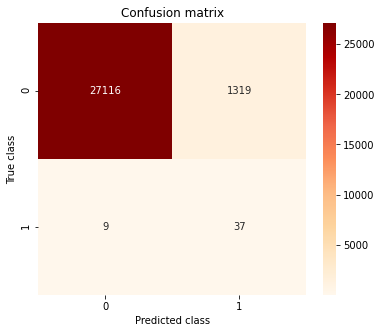

In [88]:
import matplotlib.pyplot as plt

LABELS = [0, 1] 
conf_matrix = np.array([[tn, fp],
               [fn, tp]])
plt.figure(figsize =(6,5)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d",cmap="OrRd"); 
plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show() 

### [METRICS PERFORMANCE]

### Recall

In [89]:
print("Recall: ",tp/(tp+fn))

Recall:  0.8043478260869565


### True negative rate/Specificity

In [90]:
print("Specificity: ",tn/(tn+fp))

Specificity:  0.9536135044839107


### F1 Score

In [92]:
print("F1 Score: " ,tp/(tp+((fn+fp)/2)))

F1 Score:  0.052781740370898715


### Precision

In [91]:
print("Precision: ", tp/(tp+fp))

Precision:  0.02728613569321534


### 9. BILANCIAMENTO DELLE CLASSI MEDIANTE OVERSAMPLING SMOTE

#### SECONDO APPROCCIO OVERSAMPLING

Metodo SMOTE: questa è una delle tecniche di oversampling più popolari. In questo caso si vanno a prendere le osservazioni più vicine (distanza euclidea) tra quelle delle classe minoritaria, si fa la differenza tra i due vettori di features e si moltiplica questo valore per un numero casuale tra 0 e 1. In altre parole, si va ad applicare un perturbamento alla distanza tra due punti della classe minoritaria. Così facendo si creano osservazioni artificiali che accrescono il patrimonio di dati ma non ne modificano troppo il valore.

In questo secondo approccio verrà utilizzato come dataset di training il dataset creato con la funzione SMOTE in cui avremo il 50% di transazioni fraudolente e il 50% non fraudolente. Per semplicità inoltre non verrà svolto
nessun pre processing in quanto sarebbe molto oneroso dal punto di vista computazionale.

In [93]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb # To do our transformation in a unique time
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.model_selection import train_test_split
classifier = RandomForestClassifier


### [SAMPLING]

In [94]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df,df.Class, test_size=0.3, random_state=42)

#### SMOTE 50% TRANSAZIONI FRAUDOLENTE

In [95]:
X = X_train.drop(["Class"], axis=1).values #Setting the X to do the split
y = X_train["Class"].values # transforming the values in array

# build model with SMOTE imblearn
#smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), classifier(random_state=42))
#smote_model = smote_pipeline.fit(X_train, y_train)

X_smote, y_smote = SMOTE(sampling_strategy=1).fit_resample(X, y)
colonna = ['Class']
oversampled_df = pd.concat([pd.DataFrame(y_smote, columns = colonna),pd.DataFrame(X_smote)], axis=1)

#smote_prediction = smote_model.predict(X_test)
#smote_prediction

#Showing the diference before and after the transformation used
print("normal data distribution: {}".format(Counter(y)))
print("SMOTE data distribution: {}".format(Counter(y_smote)))


normal data distribution: Counter({0: 199008, 1: 356})
SMOTE data distribution: Counter({0: 199008, 1: 199008})


In [96]:
X_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class', 'hour'],
      dtype='object')

In [97]:
oversampled_df.columns

Index(['Class',       0,       1,       2,       3,       4,       5,       6,
             7,       8,       9,      10,      11,      12,      13,      14,
            15,      16,      17,      18,      19,      20,      21,      22,
            23,      24,      25,      26,      27,      28,      29,      30],
      dtype='object')

In [98]:
X_train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,hour
2557,2105.0,-2.289565,-0.480260,0.818685,-1.706423,0.822102,-1.660326,0.944047,-0.541765,1.323156,...,0.914737,0.867888,0.422969,0.310584,-0.781488,0.392241,-0.147757,1.00,0,1.0
247823,153702.0,-0.313717,-4.064342,-3.398445,0.704011,0.101662,1.529848,1.551670,-0.036774,0.015829,...,-0.091941,-0.936215,-0.833081,-0.498728,0.651183,-0.290331,0.110360,1194.28,0,19.0
152342,97283.0,-1.809763,-0.567439,2.265186,-0.960318,-1.212537,1.516493,-1.417176,0.903421,1.961027,...,-0.424978,-0.268621,0.010121,0.466862,0.835540,-0.062385,0.088079,75.00,0,4.0
103385,68628.0,1.192319,0.178575,0.141491,0.459628,-0.049959,-0.112122,-0.163883,0.155740,-0.067566,...,-0.739862,0.116799,-0.373837,0.125470,0.130126,-0.016956,0.011937,1.98,0,20.0
8771,11951.0,-0.963451,0.700311,1.097333,-1.547626,0.669966,0.513533,0.333683,0.270900,1.381880,...,-0.470181,-0.124037,-1.388839,-0.237453,0.785347,0.349708,0.216207,37.31,0,4.0


In [99]:
oversampled_df

,Class,0,1,2,3,4,5,6,7,8,...,21,22,23,24,25,26,27,28,29,30
0,0,2105.000000,-2.289565,-0.480260,0.818685,-1.706423,0.822102,-1.660326,0.944047,-0.541765,...,-0.210837,0.914737,0.867888,0.422969,0.310584,-0.781488,0.392241,-0.147757,1.000000,1.000000
1,0,153702.000000,-0.313717,-4.064342,-3.398445,0.704011,0.101662,1.529848,1.551670,-0.036774,...,0.853186,-0.091941,-0.936215,-0.833081,-0.498728,0.651183,-0.290331,0.110360,1194.280000,19.000000
2,0,97283.000000,-1.809763,-0.567439,2.265186,-0.960318,-1.212537,1.516493,-1.417176,0.903421,...,-0.509915,-0.424978,-0.268621,0.010121,0.466862,0.835540,-0.062385,0.088079,75.000000,4.000000
3,0,68628.000000,1.192319,0.178575,0.141491,0.459628,-0.049959,-0.112122,-0.163883,0.155740,...,-0.240464,-0.739862,0.116799,-0.373837,0.125470,0.130126,-0.016956,0.011937,1.980000,20.000000
4,0,11951.000000,-0.963451,0.700311,1.097333,-1.547626,0.669966,0.513533,0.333683,0.270900,...,-0.279519,-0.470181,-0.124037,-1.388839,-0.237453,0.785347,0.349708,0.216207,37.310000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398011,1,27033.592939,-23.149491,13.451147,-25.117586,6.257887,-17.287870,-4.530001,-17.062492,15.319785,...,1.769163,-1.684588,-1.039632,0.142823,1.604731,-0.221643,1.484331,0.439115,99.990000,8.000000
398012,1,123421.392893,-5.464115,3.129405,-8.114238,7.056644,-4.658367,-1.075689,-6.481602,3.577418,...,1.715064,1.008647,-0.380363,0.087567,-0.049235,0.381656,-1.080567,-1.034548,280.559162,11.000000
398013,1,147715.021669,-0.886912,4.343907,-6.111021,5.639538,1.317022,-2.268511,-1.587538,0.652826,...,0.400914,-0.864920,-0.311263,-0.248861,0.135798,0.119610,0.799681,0.486408,0.130337,17.830731
398014,1,128872.096489,-2.686314,1.438190,-2.604921,1.553147,0.446319,0.112131,-2.659863,-4.304588,...,4.760315,-0.965389,0.399160,0.433061,-0.407872,1.582216,-0.009464,0.271632,3.897557,12.000000


### 10. APPLICAZIONE MODELLI PYSPARK MACHINE LEARNING AL DATASET OVERSAMPLING

In [100]:
 # creazione del dataframe spark
data = spark.createDataFrame(oversampled_df)
data_test =spark.createDataFrame(X_test)

In [101]:
from pyspark.sql.window import Window
win = Window().orderBy(data['0'])
data = data.withColumn("idx", row_number().over(win))

In [102]:
from pyspark.sql.window import Window
win = Window().orderBy(data_test['Time'])
data_test = data_test.withColumn("idx", row_number().over(win))

In [103]:
#### Importazione delle librerie Pyspark machine learning

from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.linalg import DenseVector

In [104]:
data.columns

['Class',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 'idx']

In [105]:
data_test.columns

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'Class',
 'hour',
 'idx']

In [106]:
#### Conversione delle colonne delle features mediante in DenseVector e creazione della variabile label e indice
training_df = data.rdd.map(lambda x: (DenseVector(x[2:30]),x[0],x[31]))

In [107]:
training_df = spark.createDataFrame(training_df,["features","label","index"])
training_df.show()

+--------------------+-----+-----+
|            features|label|index|
+--------------------+-----+-----+
|[1.19185711131486...|    0|  0.0|
|[-0.9662717115720...|    0|  1.0|
|[-1.3583540615982...|    0|  1.0|
|[-0.4259658844124...|    0|  1.0|
|[-0.8942860822028...|    0|  1.0|
|[-0.6442694423481...|    0|  1.0|
|[-0.3382617524257...|    0|  1.0|
|[1.44904378114715...|    0|  1.0|
|[1.0693735878819,...|    0|  1.0|
|[-2.7918547659339...|    0|  1.0|
|[-0.7524170429566...|    0|  1.0|
|[-0.4369050713606...|    0|  1.0|
|[-5.4012576631582...|    0|  1.0|
|[1.4929359769862,...|    0|  1.0|
|[0.69488477560733...|    0|  1.0|
|[0.96249606991485...|    0|  1.0|
|[0.24749112778366...|    0|  1.0|
|[-2.0742946722629...|    0|  1.0|
|[-0.4142888100908...|    0|  1.0|
|[1.05938711501788...|    0|  1.0|
+--------------------+-----+-----+
only showing top 20 rows



In [108]:
#### Conversione delle colonne delle features mediante in DenseVector e creazione della variabile label e indice
test_df = data_test.rdd.map(lambda x: (DenseVector(x[1:29]),x[30],x[31]))

In [109]:
test_df = spark.createDataFrame(test_df,["features","label","index"])
test_df.show()

+--------------------+-----+-----+
|            features|label|index|
+--------------------+-----+-----+
|[-1.3598071336738...|    0|  0.0|
|[-1.1582330934952...|    0|  1.0|
|[1.22965763450793...|    0|  1.0|
|[1.249998742053,-...|    0|  1.0|
|[0.38497821518095...|    0|  1.0|
|[1.10321543528383...|    0|  1.0|
|[1.16661638244228...|    0|  1.0|
|[-1.9465251312153...|    0|  1.0|
|[1.17328461017079...|    0|  1.0|
|[1.23742903021294...|    0|  1.0|
|[1.11400859541157...|    0|  1.0|
|[-0.5299122841865...|    0|  1.0|
|[-0.5353877630944...|    0|  1.0|
|[-0.5353877630944...|    0|  1.0|
|[0.99636953156604...|    0|  1.0|
|[-2.0088717945861...|    0|  1.0|
|[-0.7622556657268...|    0|  1.0|
|[-1.0632356787451...|    0|  1.0|
|[1.09552460629831...|    0|  1.0|
|[-1.1694224579643...|    0|  1.0|
+--------------------+-----+-----+
only showing top 20 rows



In [110]:
training_df.groupBy("label").count().show() #variabili nel training

+-----+------+
|label| count|
+-----+------+
|    0|199008|
|    1|199008|
+-----+------+



In [111]:
test_df.groupBy("label").count().show() # variabili nel test

+-----+-----+
|label|count|
+-----+-----+
|    0|85307|
|    1|  136|
+-----+-----+



### [MODEL TRAINING]   [MODEL TESTING]

In [112]:
gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=4) # 100 trees, con profondità 4

model = gbt.fit(training_df) #addestriamo il modello

predictions = model.transform(test_df) # facciamo la predizione sul test set
predictions

#### Vediamo le classi predette
predictions.groupBy("prediction").count().show()
predictions.groupBy("label").count().show() # label iniziali



+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|84706|
|       1.0|  737|
+----------+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|85307|
|    1|  136|
+-----+-----+



### [MODEL EVALUATION]

In [113]:
#### Calcolo percentuale dei valori reali con i valori predetti

predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))
predictions.groupBy("fraudPrediction").count().show()
predictions.groupBy("label").count().show()
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]

totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]

FraudPredictionAccuracy = (accurateFraud/totalFraud)*100

FraudPredictionAccuracy

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|  125|
|              0|85318|
+---------------+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|85307|
|    1|  136|
+-----+-----+



91.91176470588235

In [114]:
#### Matrice di confusione

tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()

tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()

fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()

fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()

print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)


True Positive:  125 
True Negative:  84695 
False Positive:  612 
False Negative:  11


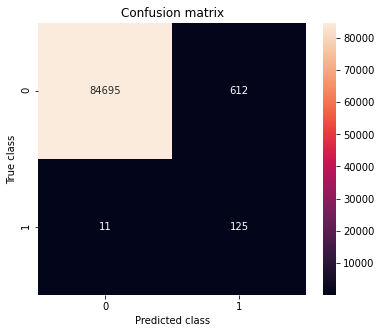

In [115]:
import matplotlib.pyplot as plt
import numpy as np

#visulalizing the confusion matrix
LABELS = [0, 1] 
conf_matrix = np.array([[tn, fp],
               [fn, tp]])
plt.figure(figsize =(6, 5)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show() 

### [METRICS PERFORMANCE]

In [116]:
### Recall

print("Recall: ",tp/(tp+fn))

### Specificity

print("Specificity: ",tn/(tn+fp))

### Precision

print("Precision: ", tp/(tp+fp))

### F1 Score

print("F1 Score: " ,tp/(tp+((fn+fp)/2)))

Recall:  0.9191176470588235
Specificity:  0.99282591112101
Precision:  0.16960651289009498
F1 Score:  0.286368843069874


#### Random Forest

In [117]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features")

### [MODEL TRAINING]

In [118]:
model = rf.fit(training_df)

### [MODEL TESTING]

In [119]:
predictions = model.transform(test_df)
predictions

DataFrame[features: vector, label: bigint, index: double, rawPrediction: vector, probability: vector, prediction: double]

In [123]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))

In [124]:
predictions.groupBy("fraudPrediction").count().show()

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|  124|
|              0|85319|
+---------------+-----+



In [125]:
predictions.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|85307|
|    1|  136|
+-----+-----+



### [MODEL EVALUATION]

In [126]:
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]

totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
totalFraud

FraudPredictionAccuracy = (accurateFraud/totalFraud)*100

FraudPredictionAccuracy

91.17647058823529

In [127]:
tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()

tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()

fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()

fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()

In [128]:
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)

True Positive:  124 
True Negative:  84460 
False Positive:  847 
False Negative:  12


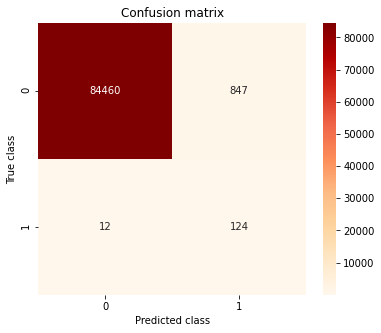

In [129]:
import matplotlib.pyplot as plt

LABELS = [0, 1] 
conf_matrix = np.array([[tn, fp],
               [fn, tp]])
plt.figure(figsize =(6,5)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d",cmap="OrRd"); 
plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show()

### [METRICS PERFORMANCE]

In [130]:
### Recall

print("Recall: ",tp/(tp+fn))

### Specificity

print("Specificity: ",tn/(tn+fp))

### Precision

print("Precision: ", tp/(tp+fp))

### F1 Score

print("F1 Score: " ,tp/(tp+((fn+fp)/2)))

Recall:  0.9117647058823529
Specificity:  0.9900711547704174
Precision:  0.12770339855818744
F1 Score:  0.2240289069557362


### [SAMPLING]

#### SMOTE 10% TRANSAZIONI FRAUDOLENTE

In [132]:
X = X_train.drop(["Class"], axis=1).values #Setting the X to do the split
y = X_train["Class"].values # transforming the values in array

# build model with SMOTE imblearn
#smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), classifier(random_state=42))
#smote_model = smote_pipeline.fit(X_train, y_train)

X_smote, y_smote = SMOTE(sampling_strategy=0.1).fit_resample(X, y)
colonna = ['Class']
oversampled_df = pd.concat([pd.DataFrame(y_smote, columns = colonna),pd.DataFrame(X_smote)], axis=1)

#smote_prediction = smote_model.predict(X_test)
#smote_prediction

#Showing the diference before and after the transformation used
print("normal data distribution: {}".format(Counter(y)))
print("SMOTE data distribution: {}".format(Counter(y_smote)))

normal data distribution: Counter({0: 199008, 1: 356})
SMOTE data distribution: Counter({0: 199008, 1: 19900})


In [133]:
 # creazione del dataframe spark
data = spark.createDataFrame(oversampled_df)
data_test =spark.createDataFrame(X_test)

win = Window().orderBy(data['0'])
data = data.withColumn("idx", row_number().over(win))

win = Window().orderBy(data_test['Time'])
data_test = data_test.withColumn("idx", row_number().over(win))



In [134]:
training_df = data.rdd.map(lambda x: (DenseVector(x[2:30]),x[0],x[31]))

training_df = spark.createDataFrame(training_df,["features","label","index"])
training_df.show()

+--------------------+-----+-----+
|            features|label|index|
+--------------------+-----+-----+
|[1.19185711131486...|    0|  0.0|
|[-0.9662717115720...|    0|  1.0|
|[-1.3583540615982...|    0|  1.0|
|[-0.4259658844124...|    0|  1.0|
|[-0.8942860822028...|    0|  1.0|
|[-0.6442694423481...|    0|  1.0|
|[-0.3382617524257...|    0|  1.0|
|[1.44904378114715...|    0|  1.0|
|[1.0693735878819,...|    0|  1.0|
|[-2.7918547659339...|    0|  1.0|
|[-0.7524170429566...|    0|  1.0|
|[-0.4369050713606...|    0|  1.0|
|[-5.4012576631582...|    0|  1.0|
|[1.4929359769862,...|    0|  1.0|
|[0.69488477560733...|    0|  1.0|
|[0.96249606991485...|    0|  1.0|
|[0.24749112778366...|    0|  1.0|
|[-2.0742946722629...|    0|  1.0|
|[-0.4142888100908...|    0|  1.0|
|[1.05938711501788...|    0|  1.0|
+--------------------+-----+-----+
only showing top 20 rows



In [135]:
test_df = data_test.rdd.map(lambda x: (DenseVector(x[1:29]),x[30],x[31]))
test_df = spark.createDataFrame(test_df,["features","label","index"])
test_df.show()

+--------------------+-----+-----+
|            features|label|index|
+--------------------+-----+-----+
|[-1.3598071336738...|    0|  0.0|
|[-1.1582330934952...|    0|  1.0|
|[1.22965763450793...|    0|  1.0|
|[1.249998742053,-...|    0|  1.0|
|[0.38497821518095...|    0|  1.0|
|[1.10321543528383...|    0|  1.0|
|[1.16661638244228...|    0|  1.0|
|[-1.9465251312153...|    0|  1.0|
|[1.17328461017079...|    0|  1.0|
|[1.23742903021294...|    0|  1.0|
|[1.11400859541157...|    0|  1.0|
|[-0.5299122841865...|    0|  1.0|
|[-0.5353877630944...|    0|  1.0|
|[-0.5353877630944...|    0|  1.0|
|[0.99636953156604...|    0|  1.0|
|[-2.0088717945861...|    0|  1.0|
|[-0.7622556657268...|    0|  1.0|
|[-1.0632356787451...|    0|  1.0|
|[1.09552460629831...|    0|  1.0|
|[-1.1694224579643...|    0|  1.0|
+--------------------+-----+-----+
only showing top 20 rows



### [MODEL TRAINING]   [MODEL TESTING]

In [136]:
gbt = GBTClassifier(featuresCol="features", maxIter=100,maxDepth=4) # 100 trees, con profondità 4

model = gbt.fit(training_df) #addestriamo il modello

predictions = model.transform(test_df) # facciamo la predizione sul test set
predictions

#### Vediamo le classi predette
predictions.groupBy("prediction").count().show()
predictions.groupBy("label").count().show() # label iniziali

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|85253|
|       1.0|  190|
+----------+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|85307|
|    1|  136|
+-----+-----+



### [MODEL EVALUATION]

In [137]:
#### Calcolo percentuale dei valori reali con i valori predetti

predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))
predictions.groupBy("fraudPrediction").count().show()
predictions.groupBy("label").count().show()
accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]

totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
FraudPredictionAccuracy = (accurateFraud/totalFraud)*100

+---------------+-----+
|fraudPrediction|count|
+---------------+-----+
|              1|  119|
|              0|85324|
+---------------+-----+

+-----+-----+
|label|count|
+-----+-----+
|    0|85307|
|    1|  136|
+-----+-----+



In [138]:
#### Matrice di confusione

tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()

tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()

fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()

fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()

print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)


True Positive:  119 
True Negative:  85236 
False Positive:  71 
False Negative:  17


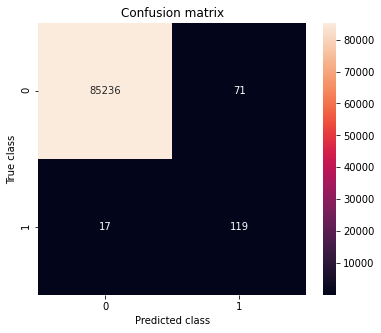

In [139]:
#visulalizing the confusion matrix
LABELS = [0, 1] 
conf_matrix = np.array([[tn, fp],
               [fn, tp]])
plt.figure(figsize =(6, 5)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d"); 
plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show() 

In [140]:

### Recall

print("Recall: ",tp/(tp+fn))

### Specificity

print("Specificity: ",tn/(tn+fp))

### Precision

print("Precision: ", tp/(tp+fp))

### F1 Score

print("F1 Score: " ,tp/(tp+((fn+fp)/2)))


Recall:  0.875
Specificity:  0.9991677119110975
Precision:  0.6263157894736842
F1 Score:  0.7300613496932515


#### Random Forest

In [141]:
from pyspark.ml.classification import RandomForestClassifier

In [142]:
rf = RandomForestClassifier(featuresCol="features")

### [MODEL TRAINING]

In [143]:
model = rf.fit(training_df)

### [MODEL TESTING]

In [144]:
predictions = model.transform(test_df)
predictions

DataFrame[features: vector, label: bigint, index: double, rawPrediction: vector, probability: vector, prediction: double]

In [145]:
predictions = predictions.withColumn("fraudPrediction",when((predictions.label==1)&(predictions.prediction==1),1).otherwise(0))


In [146]:

accurateFraud = predictions.groupBy("fraudPrediction").count().where(predictions.fraudPrediction==1).head()[1]

totalFraud = predictions.groupBy("label").count().where(predictions.label==1).head()[1]
totalFraud

FraudPredictionAccuracy = (accurateFraud/totalFraud)*100

FraudPredictionAccuracy


87.5

In [147]:

tp = predictions[(predictions.label == 1) & (predictions.prediction == 1)].count()

tn = predictions[(predictions.label == 0) & (predictions.prediction == 0)].count()

fp = predictions[(predictions.label == 0) & (predictions.prediction == 1)].count()

fn = predictions[(predictions.label == 1) & (predictions.prediction == 0)].count()


In [148]:
print("True Positive: ",tp,"\nTrue Negative: ",tn,"\nFalse Positive: ",fp,"\nFalse Negative: ",fn)


True Positive:  119 
True Negative:  85261 
False Positive:  46 
False Negative:  17


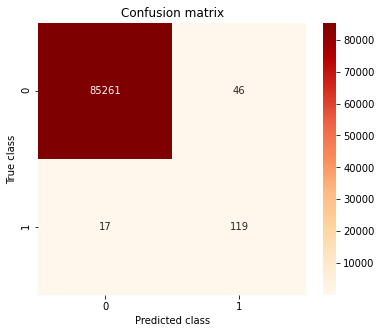

In [149]:
LABELS = [0, 1] 
conf_matrix = np.array([[tn, fp],
               [fn, tp]])
plt.figure(figsize =(6,5)) 
sns.heatmap(conf_matrix, xticklabels = LABELS, yticklabels = LABELS, annot = True, fmt ="d",cmap="OrRd"); 
plt.title("Confusion matrix") 
plt.ylabel('True class') 
plt.xlabel('Predicted class') 
plt.show()


### [METRICS PERFORMANCE]

In [150]:
### Recall

print("Recall: ",tp/(tp+fn))

### Specificity

print("Specificity: ",tn/(tn+fp))

### Precision

print("Precision: ", tp/(tp+fp))

### F1 Score

print("F1 Score: " ,tp/(tp+((fn+fp)/2)))


Recall:  0.875
Specificity:  0.9994607710973308
Precision:  0.7212121212121212
F1 Score:  0.7906976744186046


### 11. CONFRONTO TRA I MODELLI OTTENUTI CON UNDERSAMPLING E OVERSAMPLING

I due algoritmi di classificazione utilizzati sono il Gradient Boosting Tree e il Random Forest in quanto sono due algoritmi
che funzionano bene per questo tipo di dataset. 

Le metriche di cui terremo conto saranno la Recall, La Specificity e la F1 Score per avere un metodo di paragone medesimo, sebbene nel secondo approccio abbiamo molte più osservazioni per addestrare il modello.

C'è da precisare che per il primo approccio è stato preprocessato il dataset e il dataset di training conta circa 1000 osservazioni. Per quanto riguarda il secondo approccio i dataset di training sono stati due, uno di circa 220 mila osservazioni e l'altro di circa 400 mila osservazioni.

Nel primo caso la Recall e la Specificity sono risultate buone, riusciamo a prevedere le transazioni fraudolente, meno quelle non fraudolente, avendo un numero più elevato di falsi positivi. Probabilmente per via del dataset di training molto ristretto e un dataset di test molto più ampio. Nel secondo caso invece abbiamo ottenuto delle performance migliori per via del numero di osservazioni utilizzate per addestrare i modelli.

##### PRIMO APPROCCIO UNDERSAMPLING

Dataset di training bilanciato 789 transazioni (50% transazioni fraudolente, 50% transazioni leggittime).

Con il GBT abbiamo ottenuto una Recall del 89%, una Specificity del 89% e una F1 Score del 1%.
Con il Random Forest una Recall del 80%, una Specificity del 95% e una F1 Score dell'5%.


##### SECONDO APPROCCIO SMOTE

Dataset di training bilanciato 398016 (50% transazioni fraudolente, 50% transazioni leggittime).

Con il GBT abbiamo ottenuto una Recall del 91%, una Specificity del 99% e una F1 Score del 28%.
Con il Random Forest una Recall del 91%, una Specificity del 99% e una F1 Score del 22%.

Dataset di training sbilanciato 218908 (10% transazioni fraudolente, 90% transazioni leggittime).

Con il GBT  abbiamo ottenuto una Recall del 87%, una Specificity del 99% e una F1 Score del 73%.
Con il Random Forest una Recall del 87%, una Specificity del 99% e una F1 Score del 79%.

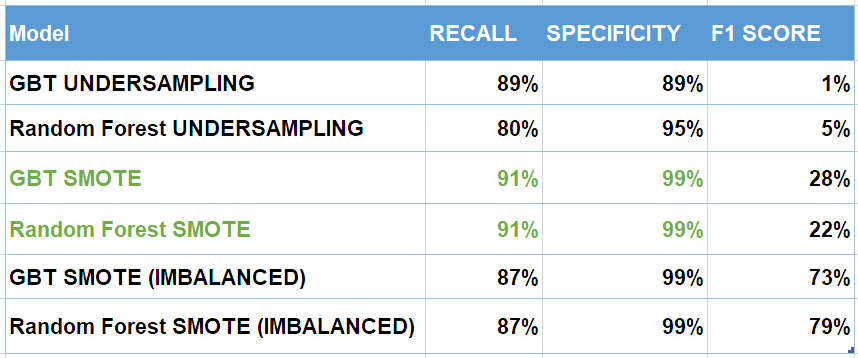

## 12. Conclusioni

Secondo il nostro obiettivo, i risultati migliori sono stati ottenuti utilizzando come metodo di campionamento del dataset la funzione SMOTE con un resampling di 1, quindi con una percentuale di transazioni fraudolente del 50%. Abbiamo visto inoltre che se utilizzassimo la un resampling di 0.1, quindi addestrando il modello su un dataset contentente solo il 10% di transazioni fraudolente riusciamo a migliorare anche i Falsi positivi. Inoltre per migliorare ancora le prestazioni si sarebbe potuto effettuare un pre-processing anche nel dataset creato con la funzione SMOTE.

Questo studio offrirà una base per gli approfondimenti che potranno essere implementati in futuro.

##### RIFERIMENTI

https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

https://github.com/scikit-learn-contrib/imbalanced-learn

https://github.com/wmlba/Fraud_Detection_Techniques

https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/

Marijan Beg, Juliette Taka, Thomas Kluyver, Alexander Konovalov, Min Ragan-Kelley, Nicolas M Thiéry, and Hans Fangohr. Using jupyter for reproducible scientific workflows. Computing in Science & Engineering, 23(2):36–46, 2021.

Fabrizio Carcillo. Beyond Supervised Learning in Credit Card Fraud Detection: A Dive into Semi-supervised and Distributed Learning. Université libre de Bruxelles, 2018.

Alberto Fernández, Salvador García, Mikel Galar, Ronaldo C Prati, Bartosz Krawczyk, and Francisco Herrera. Learning from imbalanced data sets. Springer, 2018.

Yvan Lucas and Johannes Jurgovsky. Credit card fraud detection using machine learning: a survey. arXiv preprint arXiv:2010.06479, 2020.

C Victoria Priscilla and D Padma Prabha. Credit card fraud detection: a systematic review. In International Conference on Information, Communication and Computing Technology, 290–303. Springer, 2019.

Igor Mekterović, Ljiljana Brkić, and Mirta Baranović. A systematic review of data mining approaches to credit card fraud detection. WSEAS Transactions on Business and Economics, 15:437–444, 2018.